# Pytorch Multi-output GPR

The purpose of this notebook is to predict the soil type and soil thickness of Layer 1 as a Multi-Output GP model using a ModelList. Unlike a Multi-Task model, Multi-Output models do not represent correlations between outcomes, but treat outcomes independently. 

#### Import libraries

In [1]:
!pip install torch --quiet
!pip install gpytorch --quiet

In [2]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import math
import torch
import gpytorch
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution, VariationalStrategy
from gpytorch.likelihoods import SoftmaxLikelihood
from gpytorch.distributions import MultivariateNormal
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from gpytorch.mlls import SumMarginalLogLikelihood

____________________

#### Load training data points

In [3]:
# Load the training data CSV file compiled in `1-data_access.ipynb`
input_file = '../data/2-uw_layer1_trainingdata.csv'
training_data = pd.read_csv(input_file)

# Create a GeoDataFrame from the DataFrame
training_data = gpd.GeoDataFrame(training_data, geometry=gpd.points_from_xy(training_data.LONGITUDE, training_data.LATITUDE))
    
# Set the CRS to WGS84 (latitude and longitude)
training_data.set_crs(epsg=4326, inplace=True)

training_data

,BOREHOLE_ID,BOREHOLE_NAME,BOREHOLE_TYPE,BOREHOLE_DEPTH_FT,ELEVATION_FT,LATITUDE,LONGITUDE,LAYER_NUMBER,TOP_DEPTH_FT,BOTTOM_DEPTH_FT,USCS,SIMPLE_USCS,LAYER_THICKNESS_FT,geometry,MAPPED_UNIT,SLOPE,ROUGHNESS
0,7138,B-1,Geotechnical,20.3,167.8,47.656719,-122.305728,1,0.0,1.0,SP,S,1.0,POINT (-122.30573 47.65672),Qvt,3.668571,18.199593
1,7143,B-1-92,Geotechnical,48.5,123.2,47.653642,-122.306837,1,0.0,1.0,ML,M,1.0,POINT (-122.30684 47.65364),Qvt,2.222722,10.232103
2,7144,B-2-92,Geotechnical,42.5,122.9,47.653766,-122.306468,1,0.0,1.0,ML,M,1.0,POINT (-122.30647 47.65377),Qvt,1.996012,9.385303
3,7145,B-3-92,Geotechnical,43.0,117.3,47.653256,-122.306638,1,0.0,1.0,ML,M,1.0,POINT (-122.30664 47.65326),Qvt,3.011285,14.187020
4,7146,B-4-92,Geotechnical,43.0,123.4,47.653709,-122.306259,1,0.0,0.5,SM,S,0.5,POINT (-122.30626 47.65371),Qvt,1.996012,9.385303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,143845,MW-1,Geotechnical,42.0,217.4,47.661044,-122.342453,1,0.0,7.5,SM,S,7.5,POINT (-122.34245 47.66104),Qvr,1.594538,10.106370
502,143846,MW-2,Geotechnical,43.0,218.2,47.661138,-122.342516,1,0.0,7.5,SM,S,7.5,POINT (-122.34252 47.66114),Qvr,1.340698,8.735672
503,143847,MW-3,Geotechnical,45.5,219.3,47.661276,-122.342492,1,0.0,18.0,SM,S,18.0,POINT (-122.34249 47.66128),Qvr,1.594538,10.106370
504,143848,MW-4,Geotechnical,43.0,219.1,47.661177,-122.342383,1,0.0,10.0,SM,S,10.0,POINT (-122.34238 47.66118),Qvr,1.594538,10.106370


____________________

#### Split train and test data

In [4]:
# Assuming training_data is your DataFrame
X = training_data[['MAPPED_UNIT', 'SLOPE', 'ROUGHNESS']]
y_1 = training_data['SIMPLE_USCS']
y_2 = training_data['LAYER_THICKNESS_FT']

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['MAPPED_UNIT']),  # One-hot encode categorical features
        ('num', StandardScaler(), ['SLOPE', 'ROUGHNESS'])  # Standardize numerical features
    ])

# Apply transformations and convert to dense array
X_processed = preprocessor.fit_transform(X).toarray()  # Convert to array if sparse

# Convert processed data to tensors
X_tensor = torch.tensor(X_processed, dtype=torch.float32)

# Handling target for SIMPLE_USCS
encoder = OneHotEncoder(sparse_output=False)
y_1_encoded = encoder.fit_transform(y_1.values.reshape(-1, 1))
y_1_tensor = torch.tensor(y_1_encoded, dtype=torch.float32)

# Handling target for LAYER_THICKNESS_FT
scaler = StandardScaler()
y_2_scaled = scaler.fit_transform(y_2.values.reshape(-1, 1))
y_2_tensor = torch.tensor(y_2_scaled, dtype=torch.float32)

# Split the data into training and test sets for both models
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_tensor, y_1_tensor, test_size=0.2, random_state=42)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_tensor, y_2_tensor, test_size=0.2, random_state=42)

In [5]:
# Convert from one-hot to class labels if necessary
if y_train_1.ndim > 1 and y_train_1.shape[1] > 1:
    y_train_1_labels = torch.argmax(y_train_1, dim=1)
else:
    y_train_1_labels = y_train_1

In [17]:
class GPClassificationModel(gpytorch.models.ApproximateGP):
    def __init__(self, num_features, num_classes, likelihood):
        # Initialize variational components required for the Approximate GP
        variational_distribution = CholeskyVariationalDistribution(num_features)
        inducing_points = torch.rand(num_features, num_features)  # example initialization; adjust as necessary
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        
        # Pass the variational strategy to the superclass constructor
        super(GPClassificationModel, self).__init__(variational_strategy)
        
        # Define mean and covariance modules
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        
        # Store the likelihood as an attribute of the model
        self.likelihood = likelihood

In [18]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        self.likelihood = likelihood  # Set the likelihood as an attribute of the model

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [19]:
# Create a classification model for y_train_1
num_classes = y_train_1_labels.max().item() + 1  # Assumes class labels start at 0

# Assuming likelihoods are already created
likelihood1 = SoftmaxLikelihood(num_features=num_classes, num_classes=num_classes)
likelihood2 = gpytorch.likelihoods.GaussianLikelihood()

# Instantiate models
model1 = GPClassificationModel(num_features=X_train_1.shape[1], num_classes=num_classes, likelihood=likelihood1)
model2 = ExactGPModel(X_train_2, y_train_2, likelihood=likelihood2)

# Combine the models into a list
model = gpytorch.models.IndependentModelList(model1, model2)
likelihood = gpytorch.likelihoods.LikelihoodList(likelihood1, likelihood2)

RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 13 but got size 1 for tensor number 1 in the list.

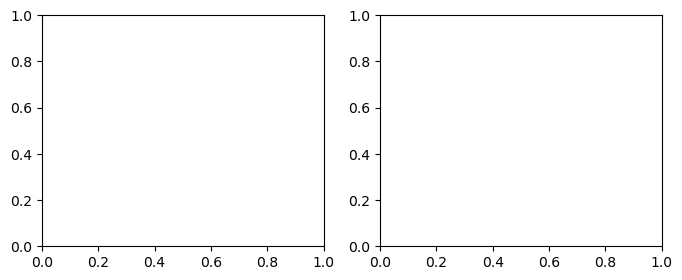

In [21]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, axs = plt.subplots(1, 2, figsize=(8, 3))

# Make predictions (use the same test points)
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    # This contains predictions for both outcomes as a list
    predictions = likelihood(*model(test_x, test_x))

for submodel, prediction, ax in zip(model.models, predictions, axs):
    mean = prediction.mean
    lower, upper = prediction.confidence_region()

    tr_x = submodel.train_inputs[0].squeeze().detach().numpy()  # Ensure inputs are properly squeezed
    tr_y = submodel.train_targets.squeeze().detach().numpy()    # Ensure targets are properly squeezed

    # Plot training data as black stars
    ax.plot(tr_x, tr_y, 'k*')
    # Predictive mean as blue line
    ax.plot(test_x.numpy(), mean.numpy(), 'b')
    # Shade in confidence
    ax.fill_between(test_x.numpy(), lower.detach().numpy(), upper.detach().numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title('Observed Values (Likelihood)')

____________________

Sources:
1. https://docs.gpytorch.ai/en/stable/examples/03_Multitask_Exact_GPs/ModelList_GP_Regression.html
2. https://jamesbrind.uk/posts/2d-gaussian-process-regression/